❗ Оставлены рекомендации ревьюера

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Задачи**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.

## Подготовка

In [ ]:
import pandas as pd
import sklearn
import numpy as np

import sys

import warnings
warnings.filterwarnings('ignore')

import re


import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet




from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [ ]:
!pip install nltk

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('C:\\Users\\HARD_REBOOT\\Downloads\\toxic_comments.csv')

In [ ]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


В столбце text — текст комментария, а toxic — целевой признак.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
df.duplicated().sum()

0

Данные выглядят адекватно, пропусков и дубликатов нет.  
Посмотрим на распределение целевого признака

In [ ]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:>

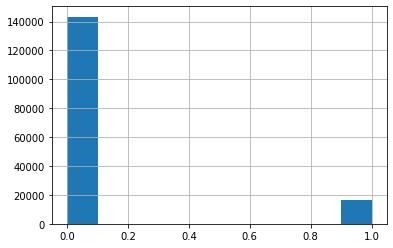

In [ ]:
df['toxic'].hist()

Есть дисбаланс, попроьуем обучить модели с ним
  
Приведём весь текст в комментариях к нижнему регистру.

In [ ]:
df['text'] = df['text'].astype(str).str.lower()

df.head(10)

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0
5,"""\n\ncongratulations from me as well, use the ...",0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Перед лемматизацией, чтобы долго не ждать, уменьшим датасет на 50% нетоксичных комментариев

In [ ]:
#df = df.drop(df.query('toxic == 0').sample(frac=.5).index)

<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера v2</b>
    
❌ Тестовая выборка должна иметь такое же распределение, как и основной датасет(иначе исказится оценка модели). Поэтому уменьшать количество строк необходимо либо только на тренировочной выборке, либо уменьшать пропорционально балансу классов.
</div>


<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Я решила ничего не уменьшать в итоге, почему-то сильно режется качество, а целый датасет не сильно дольше лемматизируется 😅  </div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v3</b>
    
✔️ Ну и отлично)
</div>

In [ ]:
#df['toxic'].value_counts()

Напишем функции очистки текста и лемматизации. Перед лемматизацией текст очистим

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemmas = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])
    return lemmas

In [ ]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

In [ ]:
%%time
df['lemmas'] = df['text'].apply(lambda text: lemmatize(clear_text(text)))

CPU times: user 17min 52s, sys: 1min 44s, total: 19min 36s
Wall time: 19min 36s


<div class="alert alert-block alert-danger">
<b>Комментарий от ревьюера v1</b>
    
❌ Твоя лемматизация отрабатывает не совсем верно. WordNetLemmatizer - требует указания POS-tag для каждого слова, иначе все слова обрабатываются как существительные.
    
В этой статье https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/ ты можешь увидеть основные подходы к лемматизации текстов, я бы рекомендовал тебе использовать spaCy - это быстрая библиотека, которая не требует проставления POS-tag.    
   
</div>


<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Я попробовала spaCy, но всё равно даже с сокращением датасета почти в 2 раза лемматизация шла больше 8 часов, я так и не дождалась. Я потом свой код поменяла на код наставника из треда прямо дословно, и всё равно ничего не поменялось. Не поняла короче, что это было 😅 Оставила в итоге WordNetLemmatizer с пос-тегами </div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v2</b>
    
✔️ Теперь у тебя все отлично. Очень странно, что spaCy работал так долго, обычно он быстрее, чем WordNet, если скинешь код, то я попробую подсказать, что с ним не так)
</div>

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Делала вот так:  
  
```
def lemmatize_text(text):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['text'] = df['text'].apply(clear_text)
df['lemm_text'] = df['text'].apply(lemmatize_text)
```
</div>

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v3</b>
    
✔️ Если ты вынесешь nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) из функции, то лемматизация будет выполняться на порядок быстрее. Сейчас у тебя для каждого текста инициализируется новый объект nlp, а зачастую это отнимает больше времени, чем сам процесс лемматизации.
</div>

In [ ]:
df.head()

,text,toxic,lemmas
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


## Обучение

Разделим данные на обучающую, валидационную и тестовую выборки, выделим признаки

In [ ]:
df_train, df_valid_1 = train_test_split(df, shuffle=False, test_size=0.2, random_state=42)

df_valid, df_test = train_test_split(df_valid_1, shuffle=False, test_size=0.50, random_state=42)

In [ ]:
features_train = df_train['lemmas']
target_train = df_train['toxic']

features_valid = df_valid['lemmas']
target_valid = df_valid['toxic']

features_test = df_test['lemmas']
target_test = df_test['toxic']

Создадим матрицу TF-IDF

In [ ]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [ ]:
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)
features_valid_tf = count_tf_idf.transform(features_valid)

**Логистическая регрессия**

In [ ]:
%%time

best_C = 0
best_score = 0

for C in [0.01, 0.1, 1, 10]:

    model_lr = LogisticRegression(class_weight = 'balanced', random_state=42, C=C)
    score = cross_val_score(model_lr, features_train_tf, target_train, cv=4, scoring='f1').mean()
    model_lr.fit(features_train_tf, target_train)
    if score > best_score:
        best_score = score
        best_C = C

print(best_score)
print(best_C)

0.7603498572264666
10
CPU times: user 2min 50s, sys: 6min 8s, total: 8min 58s
Wall time: 8min 59s


<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера v1</b>
    
✔️ Очень круто, что ты получаешь оценку на кросс-валидации, она более устойчива, чем просто оценка на валидационной выборке. Для улучшения результата я бы предложил перебрать гиперпараметр C в диапазоне [0.01, 0.1, 1, 10].
</div>

**Дерево решений**

In [ ]:
best_tree_model = None
best_tree_result = 0
best_parameters = ''

for depth in range(1, 100, 10):
    model_tree = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_split=100)
    model_tree.fit(features_train_tf, target_train)
    predictions = model_tree.predict(features_valid_tf)
    tree_result = f1_score(target_valid, predictions)
    if tree_result > best_tree_result:
        best_tree_model = model_tree
        best_tree_result = tree_result
        best_parameters = 'Глубина', depth

print("Наилучший F1:", best_tree_result)
print(best_parameters)

Наилучший F1: 0.7073256221521205
('Глубина', 91)


**Случайный лес**

In [ ]:
%%time

best_result = 0
best_depth = 0
best_est = 0

for depth in range(1, 30, 7):
    for est in range(1, 250, 50):
        forest_model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42, min_samples_split= 100)
        forest_model.fit(features_train_tf, target_train)
        predictions = forest_model.predict(features_valid_tf)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_depth = depth # наилучшая глубина
            best_result = result
            best_est = est # наилучшее количество деревьев


print('Наилучший F1:', best_result)
print('est:', best_est, 'depth:', best_depth)

Наилучший F1: 0.13144475920679885
est: 1 depth: 29
CPU times: user 1min 58s, sys: 901 ms, total: 1min 59s
Wall time: 1min 59s


**SGDClassifier**

In [ ]:
%%time

model_sgd = SGDClassifier(max_iter = 1000, n_jobs=-1)
score = cross_val_score(model_sgd, features_train_tf, target_train,cv=4,scoring='f1').mean()
model_sgd.fit(features_train_tf, target_train)

score

CPU times: user 1.53 s, sys: 566 ms, total: 2.1 s
Wall time: 2.1 s


0.6278070534119399

На валидационной выборке наилучший результат показала модель логистической регрессии (0,76) и дерева решений (0.70). Проверим работу этих моделей на тестовой выборке

**Логистическая регрессия**

In [ ]:
%%time

model_lr = LogisticRegression(class_weight = 'balanced', random_state=42, C=10)
model_lr.fit(features_train_tf, target_train)
predictions = model_lr.predict(features_test_tf)

f1_score(target_test, predictions)

CPU times: user 15 s, sys: 30.7 s, total: 45.7 s
Wall time: 45.8 s


0.7617971178298955

**Дерево решений**

In [ ]:
model_tree = DecisionTreeClassifier(random_state=42, max_depth=91, min_samples_split=100)
model_tree.fit(features_train_tf, target_train)
predictions = model_tree.predict(features_test_tf)

f1_score(target_test, predictions)

0.7225201072386058

## Выводы

Логистическая регрессия достигла порога значения метрики в 0.75, а дерево решений — нет

<div class="alert alert-block alert-success">
Комментарий от ревьюера v1
    
# Общий вывод
    
✔️ Спасибо за работу, у тебя получился хороший проект. Ты правильно выполнила кодирование текстовых данных и подготовила выборки для обучения моделей.
    
Ты не используешь GridSearchCV в этой работе, но он и не дал бы нам адекватного результата, так как без использования pipeline он сильно переобучался бы. Pipeline позволяет объединять предобработку признаков, поиск оптимальных параметров и позволяет избежать утечку таргета при кодировании всей выборки. Тут есть краткий пример того, как можно построить pipeline.
    https://scikit-learn.ru/example/sample-pipeline-for-text-feature-extraction-and-evaluation/
    
</div>

